<a href="https://colab.research.google.com/github/mdonbruce/AspNetDocs/blob/master/Module02_NumPy_Vectorized_Order_Analytics_v3_EXECUTED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛒 Vectorized Order Analytics with NumPy (Revenue, Returns, Shipping, Satisfaction)
**Hands-on In-Class Activity — Module 2 (Group-Based + Individual Practice)**

## Objective
Students will load real-world-style order data, convert columns into NumPy arrays, and apply:
- **Vectorized operations** (no row-by-row loops)
- **Indexing/slicing**
- **Boolean masking**

To compute core business metrics while discussing how **missing values** and **outliers** can affect AI/data outcomes.

**Dataset:** `module02_numpy_orders_v3.csv` (~50,000 orders)


## ✅ Colab Setup
1. Upload the dataset in Colab: **Files → Upload → `module02_numpy_orders_v3.csv`**
2. Run the notebook cells top-to-bottom.

**Rule:** Avoid Python loops for row-by-row calculations.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('module02_numpy_orders_v3.csv', parse_dates=['order_timestamp'])
print('Shape:', df.shape)
df.head()

Shape: (50000, 14)


,order_id,order_timestamp,customer_id,category,channel,state,quantity,unit_price,discount_rate,shipping_days,shipping_cost_usd,return_flag,return_amount_usd,satisfaction_score
0,1000001,2026-02-09 16:27:00,95935,Home,mobile,WA,2,40.64,0.10,9.0,16.11,0,0.0,3.5
1,1000002,2026-01-27 06:05:00,97939,Fashion,mobile,GA,2,33.22,0.29,5.0,14.18,0,0.0,3.6
2,1000003,2026-01-29 17:39:00,26608,Grocery,store,NC,6,19.68,0.09,0.0,0.00,0,0.0,3.9
3,1000004,2026-02-07 16:23:00,80844,Home,store,FL,2,41.95,0.28,1.0,0.00,0,0.0,4.3
4,1000005,2026-01-25 06:55:00,26067,Fashion,mobile,WA,5,40.50,0.18,9.0,12.98,0,0.0,3.4


## Step 1 — Inspect missing values and potential outliers
Before computing metrics, we audit the dataset for quality issues.


In [2]:
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]

,0
shipping_days,748
satisfaction_score,600
discount_rate,400


## Step 2 — Convert columns into NumPy arrays
We convert key columns to NumPy arrays to enable fast vectorized computation.


In [3]:
qty = df['quantity'].to_numpy(dtype=float)
price = df['unit_price'].to_numpy(dtype=float)
disc = df['discount_rate'].to_numpy(dtype=float)          # contains NaNs
ret_amt = df['return_amount_usd'].to_numpy(dtype=float)
ship_days = df['shipping_days'].to_numpy(dtype=float)     # contains NaNs + outliers
channel = df['channel'].to_numpy()
category = df['category'].to_numpy()

print('qty:', qty.shape, 'price:', price.shape, 'disc:', disc.shape)

qty: (50000,) price: (50000,) disc: (50000,)


## Step 3 — Compute gross vs net revenue (vectorized)
**Gross:** `quantity * unit_price`
**Net:** `gross - discount_amount - return_amount`

⚠️ Missing discount rates must be handled. We treat NaN discounts as 0.


In [4]:
disc_safe = np.nan_to_num(disc, nan=0.0)
gross = qty * price
discount_amt = gross * disc_safe
net = gross - discount_amt - ret_amt

print('Total gross revenue:', np.nansum(gross))
print('Total net revenue:', np.nansum(net))

Total gross revenue: 8615555.030000001
Total net revenue: 6743178.1266


### Visualization — Net revenue distribution
Look for skew and outliers that could distort averages and ML features.


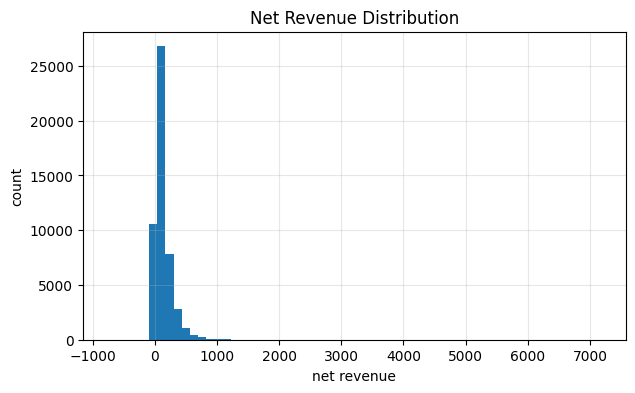

In [5]:
plt.figure(figsize=(7,4))
plt.hist(net, bins=60)
plt.title('Net Revenue Distribution')
plt.xlabel('net revenue')
plt.ylabel('count')
plt.grid(True, alpha=0.3)
plt.show()

## Step 4 — Overall return rate
Return rate = returned orders / total orders.


In [6]:
ret_flag = df['return_flag'].to_numpy(dtype=int)
print('Return rate:', ret_flag.mean())

Return rate: 0.06194


## Step 5 — Net revenue by product category (NO pandas groupby)
We compute totals using boolean masks and `np.unique`.


In [7]:
cats = np.unique(category)
net_by_cat = {}
for c in cats:
    m = (category == c)
    net_by_cat[c] = float(np.nansum(net[m]))
net_by_cat

{'Beauty': 827815.6745,
 'Electronics': 1487873.6431,
 'Fashion': 1200315.7432,
 'Grocery': 1095604.8059999999,
 'Home': 1329303.4701,
 'Sports': 802264.7897000001}

## Step 6 — Average shipping days by channel (NO pandas groupby)
We ignore missing shipping days using `~np.isnan(ship_days)`.


In [8]:
chs = np.unique(channel)
avg_ship_by_channel = {}
valid = ~np.isnan(ship_days)
for ch in chs:
    m = (channel == ch) & valid
    avg_ship_by_channel[ch] = float(ship_days[m].mean())
avg_ship_by_channel

{'marketplace': 5.0634095634095635,
 'mobile': 5.112567754947687,
 'store': 0.6339825386165212,
 'web': 5.0852343059239615}

### Outlier check — shipping days
Outliers can distort averages. Compare mean vs median.


In [9]:
ship_valid = ship_days[~np.isnan(ship_days)]
print('Shipping mean:', ship_valid.mean())
print('Shipping median:', np.median(ship_valid))
print('Max shipping days:', ship_valid.max())

Shipping mean: 4.553622187931454
Shipping median: 4.0
Max shipping days: 59.0


## Step 7 — Top 5 orders by net revenue
Use `np.argsort` to rank orders without loops.


In [10]:
top_idx = np.argsort(net)[-5:][::-1]
top_orders = df.loc[top_idx, ['order_id','category','channel','unit_price','quantity']].copy()
top_orders['net_revenue'] = net[top_idx]
top_orders

,order_id,category,channel,unit_price,quantity,net_revenue
40451,1040452,Sports,web,1450.16,5,7178.2920
292,1000293,Home,web,1670.45,4,6347.7100
11906,1011907,Grocery,web,1352.60,6,5356.2960
22369,1022370,Fashion,store,1213.24,5,4307.0020
13773,1013774,Beauty,store,690.98,6,4062.9624


## Step 8 — Reflection (Group Write-Up)
1. What patterns did you find?
2. How did missing values/outliers affect results?
3. Why is vectorization faster than loops?
4. How could these issues change a business decision?
5. What steps improve reliability (validation, imputations, monitoring)?
